In [1]:
from sklearn.metrics import adjusted_mutual_info_score as AMI 
from sklearn.metrics import adjusted_rand_score as ARI
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
from collections import Counter
import pandas as pd
import numpy as np
import csv
from collections import Counter
from scipy.stats import binom 
from statistics import mean 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


In [2]:
#function for loading hnx HG from a file

def load_graph_from_file(filename):
    with open(filename,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    HG = hnx.Hypergraph(dict(enumerate(Edges)))
    #print(len(Edges), "edges")
    return HG


#modularity calculation (return mod, EC, and DT)

def new_modularity_details(H, A, wdc=hmod.linear):

    ## all same edge weights?
    uniq = (len(Counter(H.edges.properties['weight']))==1)
    
    ## Edge Contribution
    H_id = H.incidence_dict
    d = hmod.part2dict(A)
    L = [ [d[i] for i in H_id[x]] for x in H_id ]

    ## all same weight
    if uniq:
        _ctr = Counter([ (Counter(l).most_common(1)[0][1],len(l)) for l in L])
        EC = sum([wdc(k[1],k[0])*_ctr[k] for k in _ctr.keys() if k[0] > k[1]/2])
    else:
        _keys = [ (Counter(l).most_common(1)[0][1],len(l)) for l in L]
        _vals = list(H.edge_props['weight']) ## Thanks Brenda!!
        _df = pd.DataFrame(zip(_keys,_vals), columns=['key','val'])
        _df = _df.groupby(by='key').sum()
        EC = sum([ wdc(k[1],k[0])*v[0] for (k,v) in _df.iterrows() if k[0]>k[1]/2 ])
        
    ## Degree Tax
    if uniq:        
        VolA = [sum([H.degree(i) for i in k]) for k in A]
        Ctr = Counter([H.size(i) for i in H.edges])

    else:
        ## this is the bottleneck
        VolA = np.repeat(0,1+np.max(list(d.values())))
        m = np.max([H.size(i) for i in H.edges])
        Ctr = np.repeat(0,1+m)
        S = 0
        for e in H.edges:
            w = H.edges[e].weight
            Ctr[H.size(e)] += w  
            S += w
            for v in H.edges[e]:
                VolA[d[v]] += w 
                
    VolV = np.sum(VolA)
    VolA = [x/VolV for x in VolA]
    DT = 0
    
    if uniq:        
        for d in Ctr.keys():
            Cnt = Ctr[d]
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                for Vol in VolA:
                    DT += (Cnt*wdc(d,c)*binom.pmf(c,d,Vol))
        return (EC-DT)/H.number_of_edges(), EC/H.number_of_edges(), DT/H.number_of_edges()
    else:
        for d in range(len(Ctr)):
            Cnt = Ctr[d]
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                for Vol in VolA:
                    DT += (Cnt*wdc(d,c)*binom.pmf(c,d,Vol))
        return (EC-DT)/S, EC/S, DT/S



In [3]:
#Basic statistics on hg edges with graph

def edge_statistics(edges_file):
    with open(edges_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))
    sizes = [len(Edges[i]) for i in range(len(Edges))]
    ctr_sizes = Counter(sizes)
    print("EDGE STATISTICS:")
    print("Mean size:",mean(sizes))
    print("Sizes counter:",dict(ctr_sizes))
    df = pd.DataFrame(sizes)
    df.columns = ['size']
    plt.figure(figsize=(9,4))
    sns.countplot(x = "size", data = df)
    plt.show()

#basic statistics of GT community    
    
def comm_statistics(comm_file):
    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]

    print("COMMUNITIES STATISTICS:")
    community_sizes = [len(A_gt[i]) for i in range(len(A_gt))]
    print("Number of communities", len(A_gt))
    print("Mean size:", mean(community_sizes), "min size:", min(community_sizes), "max size:", max(community_sizes) )
    print("Sizes", community_sizes)

#visualisation of edges distribution in the gt community
    
def edges_in_ground_truth_community(edge_file,partitions, show_aggr = 1, show_edge_sizes = 'all', edge_sizes_to_show = {}):
    print("")
    print("EDGES IN A GROUND-TRUTH COMMUNITY")
    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    edge_comm = []    
    for e in Edges:
        size = len(e)
        biggest = Counter([gt[int(i)-1] for i in e]).most_common(1)[0][1]
        edge_comm.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})


    to_display = {}
    to_display["lambda"] = []
    xs = np.linspace(0.501,1, 500)
    for x in xs:
        to_display["lambda"].append(x)
        
    if show_aggr == 1:
        to_display["aggr"] = []
    edges2show = []
        
    if show_edge_sizes == 'all':
        edges2show = list(set([len(e) for e in Edges]))
    else:
        edges2show = list(edge_sizes_to_show)  
        
    edges2show = sorted(edges2show)
        
        
    for i in edges2show:
        to_display[i] = []

    for x in xs:
        to_display["aggr"].append(sum(list(a["ratio"]>=x for a in edge_comm)))

    for i in edges2show:
        for x in xs:
            to_display[i].append(sum(list(a["ratio"]>=x and a["size"]==i for a in edge_comm)))

    plt.figure(figsize=(9,5))
    plt.ylim(0, to_display["aggr"][0]+50)
    
    plt.title("Number of edges captured by the partition")
    plt.xlabel("Percentage of nodes in the edge")
    plt.ylabel("Number of edges")
    df = pd.DataFrame(to_display)  
    if show_aggr == 1:
        sns.lineplot(data=df, x = "lambda", y = "aggr", label = "all sizes")
    
    for i in edges2show:
        sns.lineplot(data=df, x = "lambda", y = i, label = "size "+str(i))
        
    plt.show()
    return df

#visualisations
    
def visualise_case(edge_file,comm_file, show_aggr = 1, show_edge_sizes = 'all', edge_sizes_to_show = {}):
    edge_statistics(edge_file)
    comm_statistics(comm_file)
    df = edges_in_ground_truth_community(edge_file,comm_file, show_aggr=show_aggr,
                           show_edge_sizes = show_edge_sizes, edge_sizes_to_show = edge_sizes_to_show)
    return df

## Experiment with 4 hypergraphs

* h-ABCD hypergraphs with parameters: -n 300 -d 2.5,5,30 -c 1.5,70,120 -x 0.25 -q 0.0,0.0,0.0,0.4,0.3,0.3 -w :linear -s 555 --stats -o results_300_4more_linear_252
* senate committees dataset from: https://www.cs.cornell.edu/~arb/data/senate-committees/
* -n 1000 -d 2.5,5,50 -c 1.5,50,200 -x 0.5 -q 0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1 -w :linear -s 1234 -o linear_large_edges_1000
* contact primary school dataset from: https://www.cs.cornell.edu/~arb/data/contact-primary-school-labeled/

In [4]:
# data preparation

#case 1

#edge_file = "datasets/results_300_4more_linear_252_he.txt"
#comm_file = "datasets/results_300_4more_linear_252_assign.txt"
#algorithm_partitions = pickle.load(open("pickles/abcdh-300-linear-1.p", "rb" ))

#case 2

#edge_file = "datasets/hyperedges-senate-committees.txt"
#comm_file = "datasets/node-labels-senate-committees.txt"
#algorithm_partitions = pickle.load(open("pickles/senate-committees-1.p", "rb" ))

#case 3

#algorithm_partitions = pickle.load(open("pickles/abcdh-1000-linear-1.p", "rb" ))
#edge_file = "datasets/linear_large_edges_1000_he.txt"
#comm_file = "datasets/linear_large_edges_1000_assign.txt"

#case 4

edge_file = "datasets/hyperedges-contact-primary-school.txt"
comm_file = "datasets/node-labels-contact-primary-school.txt"
algorithm_partitions = pickle.load(open("pickles/primary-school-1.p", "rb" ))

H = load_graph_from_file(edge_file)


with open(comm_file, 'r') as file:
    gt = [int(line) for line in file]
A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]


def getAMI_ARI(HG,gt,A):
    d = hmod.part2dict(A)
    A4ari = [d[str(i+1)] for i in range(len(HG.nodes))]
    return AMI(gt, A4ari), ARI(gt, A4ari)



In [5]:
#table with all stats

def create_table_with_stats(edge_file, H, gt, partitions, keys='all'):
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))
    
    if keys == 'all':
        keys = partitions.keys()
    
    table = []
    for key in keys:
        A = partitions[key]
        table_row = {}
        table_row["partition"] = key
        table_row["#com"] = len(A)
        mod, ec, dt = new_modularity_details(H,A,wdc = hmod.linear)
        table_row["linear mod"] = mod
        table_row["linear mod EC"] = ec
        table_row["linear mod DT"] = dt
        mod, ec, dt = new_modularity_details(H,A,wdc = hmod.majority)
        table_row["majority mod"] = mod
        table_row["majority mod EC"] = ec
        table_row["majority mod DT"] = dt
        mod, ec, dt = new_modularity_details(H,A,wdc = hmod.strict)
        table_row["strict mod"] = mod
        table_row["strict mod EC"] = ec
        table_row["strict mod DT"] = dt
        ami, ari = getAMI_ARI(H,gt,A)
        table_row["AMI"] = ami
        table_row["ARI"] = ari

        d = hmod.part2dict(A)
        part = [d[str(i+1)] for i in range(len(H.nodes))]

        edge_comm_dict = []
        for e in Edges:
            size = len(e)
            biggest = Counter([part[int(i)-1] for i in e]).most_common(1)[0][1]
            edge_comm_dict.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})
        ds = set([len(e) for e in Edges])

        for d in ds:
            table_row["#"+str(d)] = sum(list(a["size"]==d  for a in edge_comm_dict))
            total = sum(list(a["biggest"]>=int(np.floor(d/2+1)) and a["size"]==d  for a in edge_comm_dict))
            
            
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                table_row["#("+str(c)+","+str(d)+")"] = sum(list(a["biggest"]==c and a["size"]==d  for a in edge_comm_dict))
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                table_row["%("+str(c)+","+str(d)+")"] = sum(list(a["biggest"]==c and a["size"]==d  for a in edge_comm_dict))*100/total


        table.append(table_row)


    df = pd.json_normalize(table)
    return df



In [6]:
import itertools
import random



def edges_in_partitions(edge_file,partitions, H, show_all = 1, show_edges = 'all', edges_to_show = {}): 
    print("")
    print("EDGES IN AN OBTAINED PARTITION")
    edge_comm_dict = {}
    for case in partitions.keys():
        d = hmod.part2dict(partitions[case])
        part = [d[str(i+1)] for i in range(len(H.nodes))]
        with open(edge_file,"r") as f:
            rd = csv.reader(f)
            lines = list(rd)
        Edges = []
        for line in lines:
            Edges.append(set(line))
        edge_comm_dict[case] = []
        for e in Edges:
            size = len(e)
            biggest = Counter([part[int(i)-1] for i in e]).most_common(1)[0][1]
            edge_comm_dict[case].append({'size': size, 'biggest': biggest, 'ratio': biggest/size})
    
    xs = np.linspace(0.501,1, 500)
    markers = itertools.cycle('ovsP<dD^+*')
    
        
    
    if show_all == 1:
        to_display = {}
        to_display["lambda"] = []
        for x in xs:
            to_display["lambda"].append(x)
        to_display[case] = []
        for case in partitions.keys(): 
            to_display[case] = []
            for x in xs:
                to_display[case].append(sum(list(a["ratio"]>=x for a in edge_comm_dict[case])))
        
        plt.figure(figsize=(9,5))
        df = pd.DataFrame(to_display) 
        plt.title("Number of edges captured by the partition")
        plt.xlabel("Percentage of nodes in the edge")
        plt.ylabel("Number of edges")
        #plt.ylim(0, to_display["all"][0]+100)
        for case in partitions.keys(): 
            sns.lineplot(data=df, x = "lambda", y = case, label = case, marker= next(markers), markersize=6, markevery=random.randrange(30, 50))
        plt.show()
        
    
    if show_edges == 'all':
        edges2show = set([len(e) for e in Edges])
    else:
        edges2show = edges_to_show   
        
    for size in edges2show:
        to_display = {}
        to_display["lambda"] = []
        for x in xs:
            to_display["lambda"].append(x)
        to_display[case] = []
        for case in partitions.keys(): 
            to_display[case] = []
            for x in xs:
                to_display[case].append(sum(list(a["ratio"]>=x and a["size"]==size  for a in edge_comm_dict[case])))
                
        plt.figure(figsize=(9,5))
        df = pd.DataFrame(to_display) 
        plt.title("Number of edges of size "+str(size)+" captured by the partition")
        plt.xlabel("Percentage of nodes in the edge")
        plt.ylabel("Number of edges")
        #plt.ylim(0, to_display["all"][0]+100)
        for case in partitions.keys(): 
            sns.lineplot(data=df, x = "lambda", y = case, label = case, marker= next(markers), markersize=6, markevery=random.randrange(30, 50))
        plt.show()

    
    return df


def edges_in_partitions_scaled(edge_file,partitions, H, show_all = 1, show_edges = 'all', edges_to_show = {}): 
    print("")
    print("EDGES IN AN OBTAINED PARTITION")
    edge_comm_dict = {}
    for case in partitions.keys():
        d = hmod.part2dict(partitions[case])
        part = [d[str(i+1)] for i in range(len(H.nodes))]
        with open(edge_file,"r") as f:
            rd = csv.reader(f)
            lines = list(rd)
        Edges = []
        for line in lines:
            Edges.append(set(line))
        edge_comm_dict[case] = []
        for e in Edges:
            size = len(e)
            biggest = Counter([part[int(i)-1] for i in e]).most_common(1)[0][1]
            edge_comm_dict[case].append({'size': size, 'biggest': biggest, 'ratio': biggest/size})
    
    xs = np.linspace(0.501,1, 500)
    markers = itertools.cycle('ovsP<dD^+*')
    
        
    
    if show_all == 1:
        to_display = {}
        to_display["lambda"] = []
        for x in xs:
            to_display["lambda"].append(x)
        to_display[case] = []
        for case in partitions.keys(): 
            to_display[case] = []
            max_value = sum(list(a["ratio"]>=xs[0] for a in edge_comm_dict[case]))
            for x in xs:
                to_display[case].append(sum(list(a["ratio"]>=x for a in edge_comm_dict[case]))/max_value)
        
        plt.figure(figsize=(9,5))
        df = pd.DataFrame(to_display) 
        plt.title("Number of edges captured by the partition")
        plt.xlabel("Percentage of nodes in the edge")
        plt.ylabel("Number of edges")
        
        for case in partitions.keys(): 
            sns.lineplot(data=df, x = "lambda", y = case, label = case, marker= next(markers), markersize=6, markevery=random.randrange(30, 50))
        plt.show()
        
    
    if show_edges == 'all':
        edges2show = set([len(e) for e in Edges])
    else:
        edges2show = edges_to_show   
        
    for size in edges2show:
        to_display = {}
        to_display["lambda"] = []
        for x in xs:
            to_display["lambda"].append(x)
        to_display[case] = []
        for case in partitions.keys(): 
            to_display[case] = []
            max_value = sum(list(a["ratio"]>=xs[0] and a["size"]==size  for a in edge_comm_dict[case]))
            for x in xs:
                if max_value > 0:
                    to_display[case].append(sum(list(a["ratio"]>=x and a["size"]==size  for a in edge_comm_dict[case]))/max_value)
                else:
                    to_display[case].append(0)
        plt.figure(figsize=(9,5))
        df = pd.DataFrame(to_display) 
        plt.title("Number of edges of size "+str(size)+" captured by the partition")
        plt.xlabel("Percentage of nodes in the edge")
        plt.ylabel("Number of edges")
        #plt.ylim(0, to_display["all"][0]+100)
        for case in partitions.keys(): 
            sns.lineplot(data=df, x = "lambda", y = case, label = case, marker= next(markers), markersize=6, markevery=random.randrange(30, 50))
        plt.show()

    
    return df




EDGE STATISTICS:
Mean size: 2.4188444584382873
Sizes counter: {2: 7748, 3: 4600, 4: 347, 5: 9}


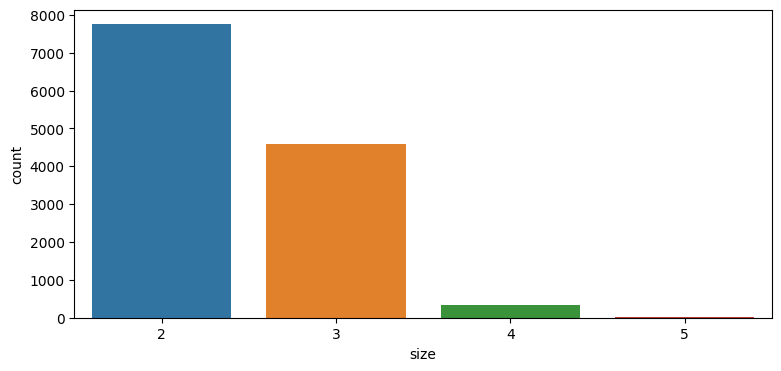

COMMUNITIES STATISTICS:
Number of communities 11
Mean size: 22 min size: 10 max size: 26
Sizes [24, 22, 21, 10, 22, 23, 23, 25, 26, 23, 23]

EDGES IN A GROUND-TRUTH COMMUNITY


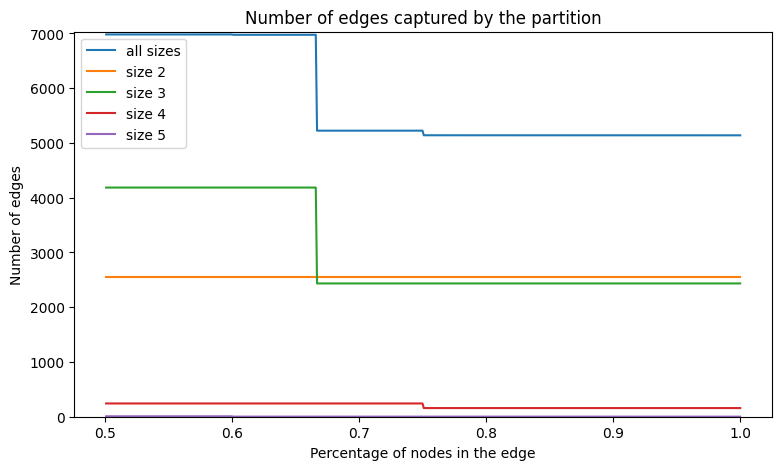

In [15]:
df = visualise_case(edge_file,comm_file)

In [7]:
#print(algorithm_partitions.keys())
all_keys = ['gt','ML', 'KU', 'KU_nls_linear', 'KU_nls_majority', 'KU_nls_strict', 'hL linear v1', 
            'hL linear v1 + ls', 'hL linear v2', 'hL linear v2 + ls', 'hL majority v1', 'hL majority v1 + ls', 
            'hL majority v2', 'hL majority v2 + ls', 'hL strict v1', 'hL strict v1 + ls', 
            'hL strict v2', 'hL strict v2 + ls']
linear_keys = ['gt','ML', 'KU', 'KU_nls_linear', 'hL linear v1', 'hL linear v1 + ls', 'hL linear v2', 'hL linear v2 + ls']
majority_keys = ['gt','ML', 'KU', 'KU_nls_majority', 'hL majority v1', 'hL majority v1 + ls', 'hL majority v2', 'hL majority v2 + ls']
strict_keys = ['gt','ML', 'KU', 'KU_nls_strict', 'hL strict v1', 'hL strict v1 + ls', 'hL strict v2', 'hL strict v2 + ls', 'gt']



basic_columns = ['partition', '#com', 'linear mod', 'linear mod EC', 'linear mod DT',
       'majority mod', 'majority mod EC', 'majority mod DT', 'strict mod',
       'strict mod EC', 'strict mod DT', 'AMI', 'ARI']






In [8]:
keys = all_keys  # linear_case
columns = basic_columns

df = create_table_with_stats(edge_file, H, gt, algorithm_partitions, keys=keys)
all_columns = df.columns
distribution_columns = ['partition']
distribution_columns.extend(all_columns[13:-1])


In [9]:
#distribution_columns

In [10]:
df[columns]

,partition,#com,linear mod,linear mod EC,linear mod DT,majority mod,majority mod EC,majority mod DT,strict mod,strict mod EC,strict mod DT,AMI,ARI
0,gt,11,0.372190,0.501711,0.129521,0.387525,0.549512,0.161987,0.340172,0.404518,0.064346,1.000000,1.000000
1,ML,6,0.404998,0.635655,0.230657,0.380283,0.664594,0.284311,0.453970,0.576590,0.122620,0.802531,0.623231
2,KU,6,0.404998,0.635655,0.230657,0.380283,0.664594,0.284311,0.453970,0.576590,0.122620,0.802531,0.623231
3,KU_nls_linear,6,0.404998,0.635655,0.230657,0.380283,0.664594,0.284311,0.453970,0.576590,0.122620,0.802531,0.623231
4,KU_nls_majority,6,0.403522,0.633113,0.229591,0.380757,0.663807,0.283050,0.448579,0.570529,0.121950,0.784914,0.609660
5,KU_nls_strict,6,0.404998,0.635655,0.230657,0.380283,0.664594,0.284311,0.453970,0.576590,0.122620,0.802531,0.623231
6,hL linear v1,8,0.408956,0.600063,0.191107,0.394279,0.630589,0.236310,0.437789,0.537941,0.100152,0.873452,0.761198
7,hL linear v1 + ls,8,0.408956,0.600063,0.191107,0.394279,0.630589,0.236310,0.437789,0.537941,0.100152,0.873452,0.761198
8,hL linear v2,8,0.408956,0.600063,0.191107,0.394279,0.630589,0.236310,0.437789,0.537941,0.100152,0.873452,0.761198
9,hL linear v2 + ls,8,0.408956,0.600063,0.191107,0.394279,0.630589,0.236310,0.437789,0.537941,0.100152,0.873452,0.761198


In [11]:
df[distribution_columns]



,partition,#2,"#(2,2)","%(2,2)",#3,"#(2,3)","#(3,3)","%(2,3)","%(3,3)",#4,"#(3,4)","#(4,4)","%(3,4)","%(4,4)",#5,"#(3,5)","#(4,5)","#(5,5)","%(3,5)","%(4,5)"
0,gt,7748,2546,100.0,4600,1751,2434,41.839904,58.160096,347,84,158,34.710744,65.289256,9,6,1,1,75.000000,12.500000
1,ML,7748,3697,100.0,4600,1054,3385,23.744087,76.255913,347,58,240,19.463087,80.536913,9,3,3,3,33.333333,33.333333
2,KU,7748,3697,100.0,4600,1054,3385,23.744087,76.255913,347,58,240,19.463087,80.536913,9,3,3,3,33.333333,33.333333
3,KU_nls_linear,7748,3697,100.0,4600,1054,3385,23.744087,76.255913,347,58,240,19.463087,80.536913,9,3,3,3,33.333333,33.333333
4,KU_nls_majority,7748,3673,100.0,4600,1120,3331,25.162885,74.837115,347,60,240,20.000000,80.000000,9,3,2,4,33.333333,22.222222
5,KU_nls_strict,7748,3697,100.0,4600,1054,3385,23.744087,76.255913,347,58,240,19.463087,80.536913,9,3,3,3,33.333333,33.333333
6,hL linear v1,7748,3426,100.0,4600,1119,3191,25.962877,74.037123,347,52,215,19.475655,80.524345,9,3,3,2,37.500000,37.500000
7,hL linear v1 + ls,7748,3426,100.0,4600,1119,3191,25.962877,74.037123,347,52,215,19.475655,80.524345,9,3,3,2,37.500000,37.500000
8,hL linear v2,7748,3426,100.0,4600,1119,3191,25.962877,74.037123,347,52,215,19.475655,80.524345,9,3,3,2,37.500000,37.500000
9,hL linear v2 + ls,7748,3426,100.0,4600,1119,3191,25.962877,74.037123,347,52,215,19.475655,80.524345,9,3,3,2,37.500000,37.500000


In [12]:
algorithm_partitions['gt'] = A_gt
all_keys = ['gt','ML', 'KU', 'KU_nls_linear', 'KU_nls_majority', 'KU_nls_strict',
                 'hL linear v1', 'hL linear v1 + ls', 'hL linear v2', 'hL linear v2 + ls', 
                 'hL majority v1', 'hL majority v1 + ls', 'hL majority v2',
                 'hL majority v2 + ls', 'hL strict v1', 'hL strict v1 + ls', 'hL strict v2', 'hL strict v2 + ls']

selected_keys = ['gt','ML', 'KU', 'KU_nls_linear', 'KU_nls_majority', 'KU_nls_strict', 'hL strict v2']
#selected_keys = ['ML', 'KU', 'KU_nls_linear','gt','hL linear v2'] 



selected_results = {}
for key in selected_keys:
    selected_results[key] = algorithm_partitions[key]



EDGES IN AN OBTAINED PARTITION


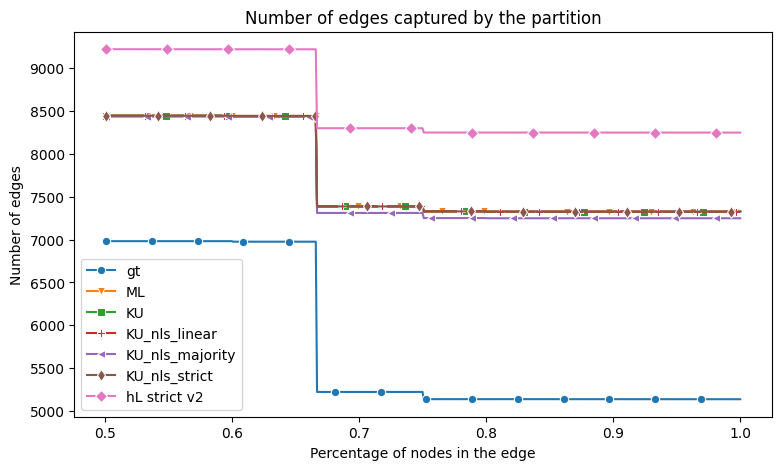

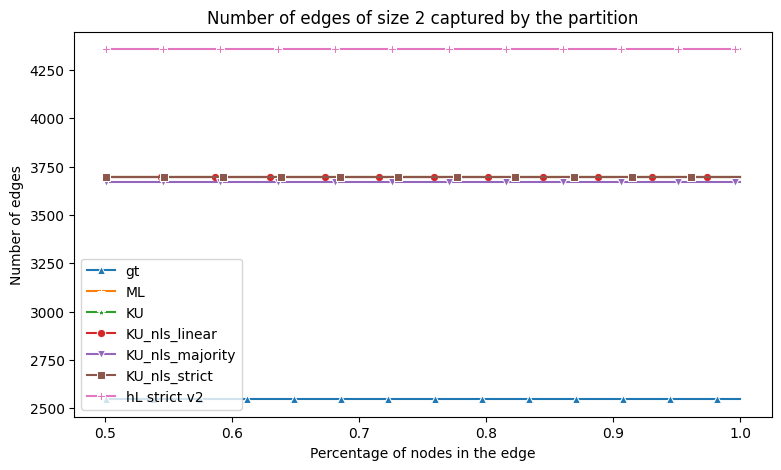

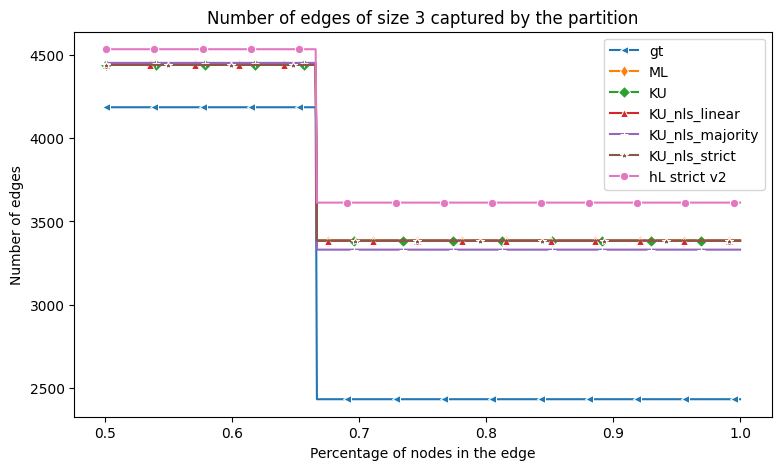

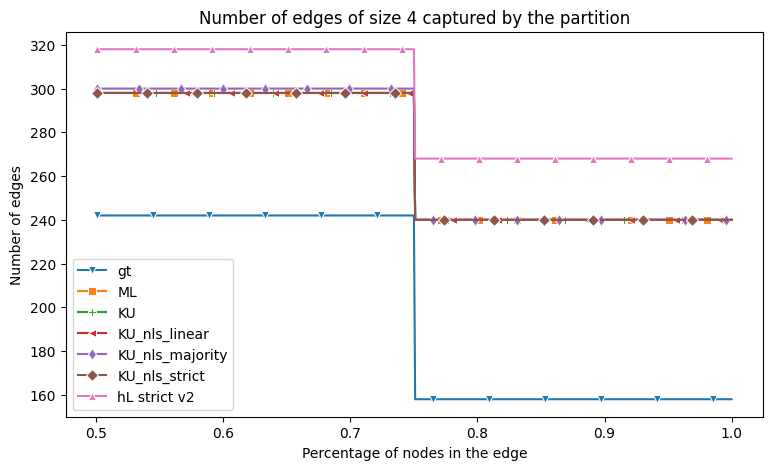

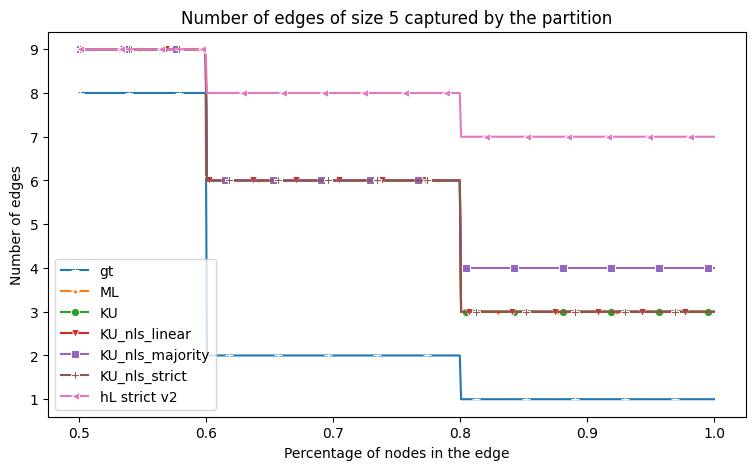

In [13]:
df = edges_in_partitions(edge_file, selected_results , H, show_all = 1, show_edges = 'all', edges_to_show = {} )


EDGES IN AN OBTAINED PARTITION


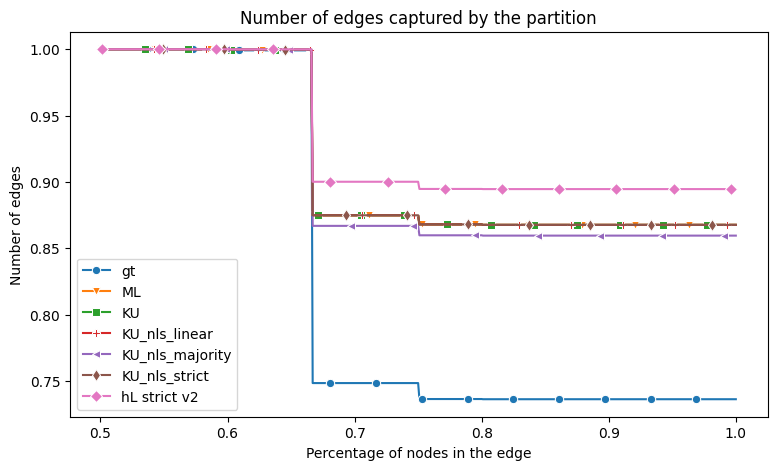

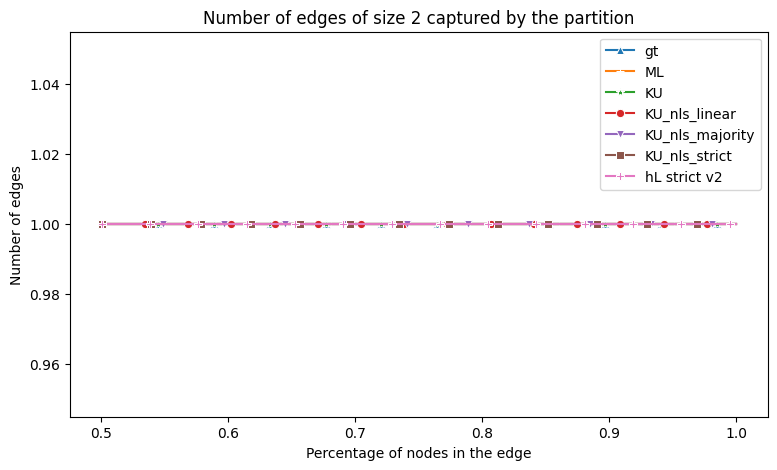

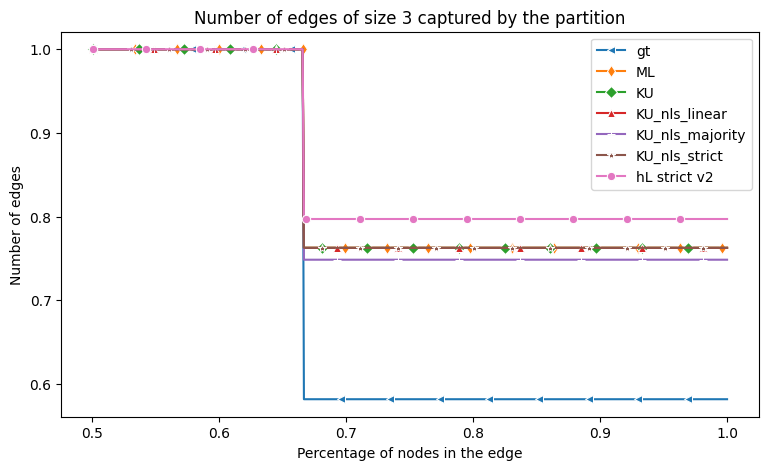

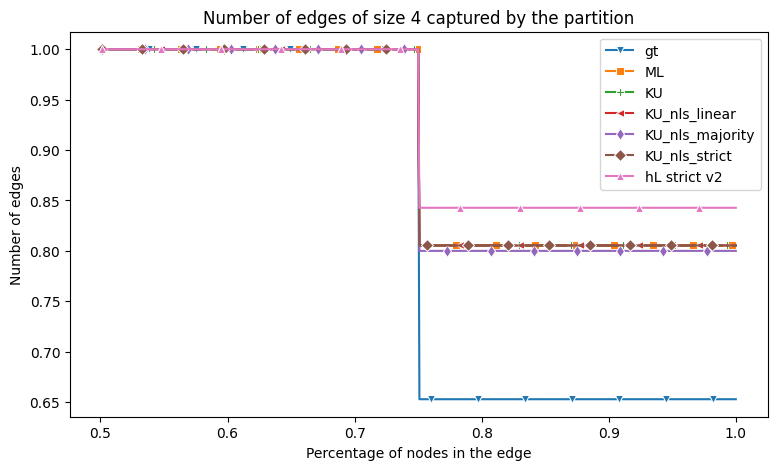

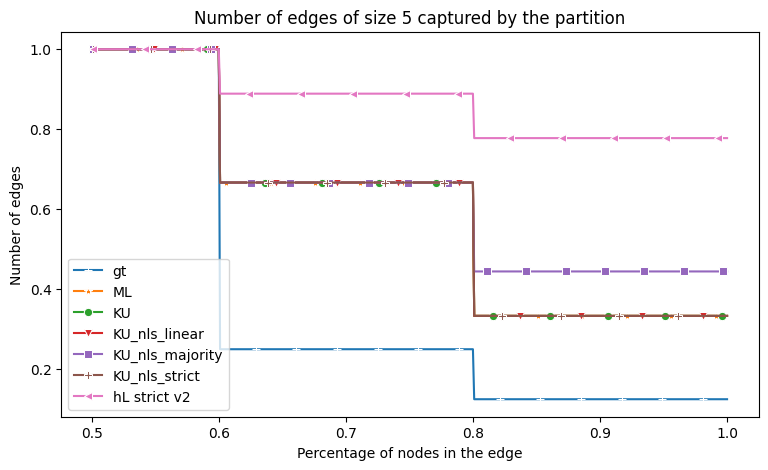

In [14]:
df = edges_in_partitions_scaled(edge_file, selected_results , H, show_all = 1, show_edges = 'all', edges_to_show = {} )